<a href="https://colab.research.google.com/github/valeriad0l/Voice-Based-Sentiment-Analysis/blob/main/Voice_Based_Sentiment_Analysis_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Voice-Based Sentiment Analysis using RAVDESS Dataset

In [ ]:
!pip install librosa pydub matplotlib seaborn scikit-learn --quiet

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Kaggle setup
from google.colab import files
files.upload()  # Upload your kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0


In [ ]:
import zipfile
with zipfile.ZipFile("ravdess-emotional-speech-audio.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess_data")

In [ ]:
# Step 1: Preprocess labels from filenames
emotion_map = {
    '01': 'neutral',
    '03': 'happy',
    '04': 'sad'
}

filepaths, emotions = [], []
for root, dirs, files in os.walk("ravdess_data"):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split('-')
            emotion_code = parts[2]
            if emotion_code in emotion_map:
                filepaths.append(os.path.join(root, file))
                emotions.append(emotion_map[emotion_code])

df = pd.DataFrame({'file': filepaths, 'label': emotions})
print(f"Total usable files: {len(df)}")
print(df['label'].value_counts())

Total usable files: 960
label
sad        384
happy      384
neutral    192
Name: count, dtype: int64


In [ ]:
# Step 2: Convert audio to mel spectrograms with optional augmentation
def audio_to_mel_spectrogram(file_path, n_mels=128, max_len=128, augment=False):
    y, sr = librosa.load(file_path, sr=None)
    if augment:
        if np.random.rand() < 0.5:
            y = librosa.effects.pitch_shift(y, sr, n_steps=np.random.uniform(-2, 2))
        if np.random.rand() < 0.5:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

In [ ]:
# Step 3: Prepare X and y
label_to_index = {'happy': 0, 'sad': 1, 'neutral': 2}
X, y = [], []

for i, row in tqdm(df.iterrows(), total=len(df)):
    mel = audio_to_mel_spectrogram(row['file'])
    X.append(mel)
    y.append(label_to_index[row['label']])

X = np.array(X)[..., np.newaxis]  # (num_samples, 128, 128, 1)
y = to_categorical(np.array(y), num_classes=3)

100%|██████████| 960/960 [00:32<00:00, 29.10it/s]


In [ ]:
# Step 4: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Step 5: CNN Model
model = keras.Sequential([
    layers.Input(shape=(128, 128, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.3390 - loss: 22.7162 - val_accuracy: 0.4583 - val_loss: 1.0343
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4764 - loss: 1.0851 - val_accuracy: 0.5729 - val_loss: 1.0432
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5754 - loss: 1.0009 - val_accuracy: 0.5781 - val_loss: 0.9115
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6400 - loss: 0.8831 - val_accuracy: 0.6146 - val_loss: 0.8561
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6895 - loss: 0.7155 - val_accuracy: 0.6510 - val_loss: 0.7989
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7800 - loss: 0.6078 - val_accuracy: 0.6615 - val_loss: 0.7548
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8149 - loss: 0.4510 - val_accuracy: 0.8021 - val_loss: 0.5420
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9443 - loss: 0.2168 - val_accuracy: 0.8542 - 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        77
           1       0.95      0.92      0.93        77
           2       0.89      0.89      0.89        38

    accuracy                           0.93       192
   macro avg       0.92      0.92      0.92       192
weighted avg       0.93      0.93      0.93       192



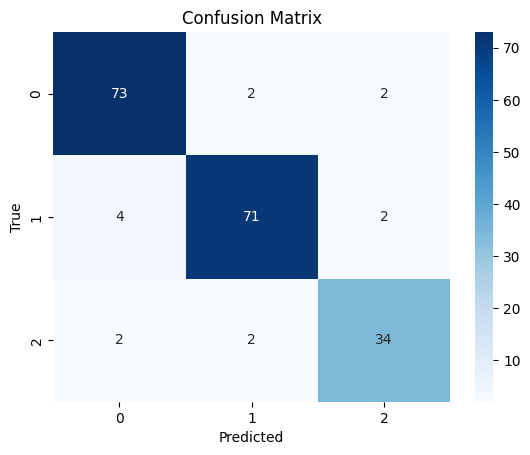

In [ ]:
# Step 6: Evaluation
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_labels))

cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()